In [1]:
from paretoKnapsackRestaurants import *

import shutil
import matplotlib as mpl

# Enable LaTeX rendering if available (fallback to Matplotlib text otherwise)
if shutil.which("latex"):
    mpl.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "text.latex.preamble": r"\usepackage{amsmath}\usepackage{amssymb}"
    })
else:
    mpl.rcParams.update({"text.usetex": False})

In [2]:
# function to sample numItems from the dataset
def sample_dataset(simMatrix, item_ids, item_costs, numItems, random_seed=None):
    '''
    Samples a subset of items from the dataset.
    Args:
        simMatrix (np.ndarray): Similarity matrix of shape (N, N).
        item_ids (list): List of item IDs of length N.
        item_costs (list): List of item costs of length N.
        numItems (int): Number of items to sample.
        random_seed (int | None): Optional seed for reproducibility.
    Returns:
        sampled_simMatrix (np.ndarray): Sampled similarity matrix of shape (numItems, numItems).
        sampled_item_ids (list): List of sampled item IDs of length numItems.
        sampled_item_costs (list): List of sampled item costs of length numItems.
    '''
    rng = np.random.default_rng(random_seed)
    sampled_indices = rng.choice(len(item_ids), size=numItems, replace=False)
    sampled_simMatrix = simMatrix[np.ix_(sampled_indices, sampled_indices)]
    sampled_item_ids = [item_ids[i] for i in sampled_indices]
    sampled_item_costs = [item_costs[i] for i in sampled_indices]

    return sampled_simMatrix, sampled_item_ids, sampled_item_costs

### Yelp - Single Sample Plotting

In [3]:
def findSingleSampleSolutions(simMatrix, item_ids, item_costs, sample_size, maxBudget, dataset_name=None, random_seed=None, plot_algos=None, sample_indices=None):
    '''
    Run algorithms for one or more random samples and plot results (no averaging or interpolation).
    Args:
        simMatrix (np.ndarray): Similarity matrix of shape (N, N).
        item_ids (list): List of item IDs of length N.
        item_costs (list): List of item costs of length N.
        sample_size (int): Number of items to sample from the dataset.
        maxBudget (float): Maximum budget for the knapsack problem.
        dataset_name (str | None): Optional dataset name for output file naming.
        random_seed (int | None): Optional base seed for reproducibility.
        plot_algos (dict | None): Optional dict of algorithm name -> bool to control plotting.
        sample_indices (iterable | None): Indices of samples to run (used to offset the base seed).
    '''
    # Cost grid (same for all budgets within this sample)
    num_steps, min_cost = 15, 1
    cost_arr = np.linspace(min_cost, maxBudget, num_steps)

    all_algo_names = ["PlainGreedy", "GreedyPlus-1Guess", "ParetoGreedy-Knapsack", "cov-epsgrid-greedy", "cost-epsgrid-greedy", "coverage-cost-grid-union-pareto", "TopK"]
    if plot_algos is None:
        plot_algos = {alg: True for alg in all_algo_names}
    algo_names = [alg for alg in all_algo_names if plot_algos.get(alg, False)]

    if sample_indices is None:
        sample_indices = [0]
    sample_indices = list(sample_indices)
    if len(sample_indices) == 0:
        raise ValueError("No valid sample indices provided.")

    def sort_pairs(costs, objs):
        if len(costs) == 0:
            return np.array([]), np.array([])
        pairs = sorted(zip(costs, objs), key=lambda x: x[0])
        return np.array([p[0] for p in pairs], dtype=float), np.array([p[1] for p in pairs], dtype=float)

    def format_points(costs, objs):
        return [f"({c:.2f}, {v:.3f})" for c, v in zip(costs, objs)]

    # Plot
    colors = plt.get_cmap("tab10").colors
    marker_map = {
        "ParetoGreedy-Knapsack": "D",
        "cov-epsgrid-greedy": "o",
        "cost-epsgrid-greedy": "X",
        "coverage-cost-grid-union-pareto": "^",
        "PlainGreedy": "s",
        "GreedyPlus-1Guess": "v",
        "TopK": "P"
    }
    marker_sizes = {"ParetoGreedy-Knapsack": 6, "cov-epsgrid-greedy": 7, "cost-epsgrid-greedy": 7, "coverage-cost-grid-union-pareto": 7, "PlainGreedy": 6, "GreedyPlus-1Guess": 6, "TopK": 6}
    linestyle_map = {"ParetoGreedy-Knapsack": '-', "cov-epsgrid-greedy": '-', "cost-epsgrid-greedy": '-', "coverage-cost-grid-union-pareto": '-', "PlainGreedy": ':', "GreedyPlus-1Guess": '-.', "TopK": ':'}
    zorder_map = {"ParetoGreedy-Knapsack": 8, "cov-epsgrid-greedy": 7, "cost-epsgrid-greedy": 6, "coverage-cost-grid-union-pareto": 5, "TopK": 4, "GreedyPlus-1Guess": 3, "PlainGreedy": 1}
    alpha_map = {"ParetoGreedy-Knapsack": 0.9, "cov-epsgrid-greedy": 0.95, "cost-epsgrid-greedy": 0.95, "coverage-cost-grid-union-pareto": 0.95, "TopK": 0.9, "GreedyPlus-1Guess": 0.9, "PlainGreedy": 0.9}
    mfc_map = {"ParetoGreedy-Knapsack": None, "cov-epsgrid-greedy": "white", "cost-epsgrid-greedy": "white", "coverage-cost-grid-union-pareto": "white", "TopK": "white", "GreedyPlus-1Guess": None, "PlainGreedy": None}

    n_samples = len(sample_indices)
    n_rows, n_cols = 2, 3
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 8))
    axes = np.array(axes).reshape(-1)
    legend_handles = None
    legend_labels = None

    runtime_totals = {alg: 0.0 for alg in all_algo_names}

    for ax_idx, sample_idx in enumerate(sample_indices):
        ax = axes[ax_idx]
        seed = None if random_seed is None else random_seed + sample_idx

        # sample the dataset once per sample index
        sampled_simMatrix, sampled_item_ids, sampled_item_costs = sample_dataset(
            simMatrix, item_ids, item_costs, sample_size, random_seed=seed
        )

        # Pareto Greedy + Coverage Linear (computed once at full budget)
        paretoRest_full = paretoKnapsackRestaurants(n_items=sampled_item_ids,
                                                    costs=sampled_item_costs,
                                                    simMatrix=sampled_simMatrix,
                                                    budget=maxBudget)
        pg1_costs, pg1_objectives, _, pg1_time = paretoRest_full.prefixParetoGreedy_1Guess()
        cl_costs, cl_objectives, _, cl_time = paretoRest_full.coverage_epsilon_grid()
        ce_costs, ce_objectives, _, ce_time = paretoRest_full.cost_epsilon_grid()
        union_costs, union_objectives = paretoRest_full.coverage_cost_grid_union_pareto(
            (ce_costs, ce_objectives), (cl_costs, cl_objectives)
        )

        # Per-budget results
        objectives = {alg: [] for alg in all_algo_names}
        runtimes = {alg: [] for alg in all_algo_names}

        for budgetVal in cost_arr:
            paretoRest = paretoKnapsackRestaurants(n_items=sampled_item_ids,
                                                   costs=sampled_item_costs,
                                                   simMatrix=sampled_simMatrix,
                                                   budget=budgetVal)

            # Plain Greedy
            plain_items, curr_objective, curr_cost, runTime = paretoRest.plainGreedy()
            objectives['PlainGreedy'].append(curr_objective)
            runtimes['PlainGreedy'].append(runTime)

            # One Guess Greedy Plus
            _, curr_objective, curr_cost, runTime = paretoRest.oneGuessGreedyPlus()
            objectives['GreedyPlus-1Guess'].append(curr_objective)
            runtimes['GreedyPlus-1Guess'].append(runTime)

            # Top-k (use #items chosen by PlainGreedy)
            k_val = max(1, len(plain_items))
            _, curr_objective, curr_cost, runTime = paretoRest.top_k(k_val)
            objectives['TopK'].append(curr_objective)
            runtimes['TopK'].append(runTime)

        runtimes['ParetoGreedy-Knapsack'].append(pg1_time)
        runtimes['cov-epsgrid-greedy'].append(cl_time)
        runtimes['cost-epsgrid-greedy'].append(ce_time)
        runtimes['coverage-cost-grid-union-pareto'].append(0.0)

        # Log pareto points per algorithm
        pg_costs_sorted, pg_objs_sorted = sort_pairs(pg1_costs, pg1_objectives)
        cl_costs_sorted, cl_objs_sorted = sort_pairs(cl_costs, cl_objectives)
        ce_costs_sorted, ce_objs_sorted = sort_pairs(ce_costs, ce_objectives)
        union_costs_sorted, union_objs_sorted = sort_pairs(union_costs, union_objectives)
        logging.info("Sample %d pareto points - ParetoGreedy-Knapsack: %s", sample_idx, format_points(pg_costs_sorted, pg_objs_sorted))
        logging.info("Sample %d pareto points - cov-epsgrid-greedy: %s", sample_idx, format_points(cl_costs_sorted, cl_objs_sorted))
        logging.info("Sample %d pareto points - cost-epsgrid-greedy: %s", sample_idx, format_points(ce_costs_sorted, ce_objs_sorted))
        logging.info("Sample %d pareto points - coverage-cost-grid-union-pareto: %s", sample_idx, format_points(union_costs_sorted, union_objs_sorted))
        logging.info("Sample %d pareto points - PlainGreedy: %s", sample_idx, format_points(cost_arr, objectives['PlainGreedy']))
        logging.info("Sample %d pareto points - GreedyPlus-1Guess: %s", sample_idx, format_points(cost_arr, objectives['GreedyPlus-1Guess']))
        logging.info("Sample %d pareto points - TopK: %s", sample_idx, format_points(cost_arr, objectives['TopK']))

        series_map = {
            "ParetoGreedy-Knapsack": sort_pairs(pg1_costs, pg1_objectives),
            "cov-epsgrid-greedy": sort_pairs(cl_costs, cl_objectives),
            "cost-epsgrid-greedy": sort_pairs(ce_costs, ce_objectives),
            "coverage-cost-grid-union-pareto": sort_pairs(union_costs, union_objectives),
            "PlainGreedy": (cost_arr, np.array(objectives['PlainGreedy'], dtype=float)),
            "GreedyPlus-1Guess": (cost_arr, np.array(objectives['GreedyPlus-1Guess'], dtype=float)),
            "TopK": (cost_arr, np.array(objectives['TopK'], dtype=float))
        }

        for i, alg in enumerate(algo_names):
            color = colors[i % len(colors)]
            marker = marker_map.get(alg, 'o')
            x_vals, y_vals = series_map[alg]
            label_text = alg.replace('_', r'\_')
            ax.plot(x_vals, y_vals,
                    label=(rf"\texttt{{{label_text}}}" if ax_idx == 0 else "_nolegend_"),
                    color=color,
                    linestyle=linestyle_map.get(alg, ':'),
                    marker=marker,
                    markersize=marker_sizes.get(alg, 6),
                    markeredgewidth=1.2,
                    markeredgecolor='k',
                    markerfacecolor=(mfc_map.get(alg) if mfc_map.get(alg) is not None else color),
                    linewidth=1.8,
                    alpha=alpha_map.get(alg, 0.9),
                    zorder=zorder_map.get(alg, 1))

        ax.set_title("")
        ax.grid(alpha=0.3)
        ax.tick_params(axis='both', labelsize=24)

        if ax_idx == 0:
            legend_handles, legend_labels = ax.get_legend_handles_labels()

        for alg in all_algo_names:
            total_runtime = float(np.nansum(np.array(runtimes.get(alg, []), dtype=float)))
            runtime_totals[alg] += total_runtime

    for ax in axes[n_samples:]:
        ax.axis('off')

    if legend_handles is not None:
        fig.legend(legend_handles, legend_labels, loc='upper center', ncol=3, fontsize=18, frameon=False)

    for r in range(n_rows):
        for c in range(n_cols):
            idx = r * n_cols + c
            if idx >= len(axes):
                continue
            ax = axes[idx]
            if r == n_rows - 1:
                ax.set_xlabel(r'Cost ($c_\ell$)', fontsize=24)
            if c == 0:
                ax.set_ylabel(r'Objective value ($f$)', fontsize=24)

    fig.tight_layout(rect=[0.03, 0.03, 1, 0.9])

    # Save figure
    from pathlib import Path
    base_dir = Path.cwd().resolve().parents[1]
    plots_dir = base_dir / "plots" / "knapsack" / "single"
    plots_dir.mkdir(parents=True, exist_ok=True)
    safe_name = (dataset_name or "dataset").replace(" ", "_")
    out_path = plots_dir / f"{safe_name}_knapsack_single_sample.pdf"
    fig.savefig(out_path, bbox_inches="tight")

    plt.show()

    # Runtime summary (seconds)
    runtime_lines = ["Runtime summary (seconds):"]
    for alg in algo_names:
        total_runtime = float(np.nansum(np.array(runtime_totals.get(alg, []), dtype=float)))
        runtime_lines.append(f"  - {alg}: {total_runtime:.3f}")
    print("\n".join(runtime_lines))

### Yelp Phoenix Single Sample

In [4]:
# Import Yelp dataset
data_path = '../../datasets/pickled_data/yelp/yelp_phoenix_'

# Import pickled data
with open(data_path + 'ids.pkl', "rb") as fp:
    phoenix_ids = pickle.load(fp)

with open(data_path + 'sim.pkl', "rb") as fp:
    phoenix_simMatrix = pickle.load(fp)

with open(data_path + 'costs.pkl', "rb") as fp:
    phoenix_costs = pickle.load(fp)

2026-02-03 17:09:19,936 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:10, Budget=150
2026-02-03 17:09:19,945 |INFO: CoverageLinear epsilon grid: eps=0.100, min_obj=1.162, max_obj=10.000, points=24
2026-02-03 17:09:19,953 |INFO: Cost epsilon grid: eps=0.100, min_cost=0.089, max_budget=150.000, points=79
2026-02-03 17:09:20,506 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:10, Budget=1.0
2026-02-03 17:09:20,507 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:10, Budget=11.642857142857142
2026-02-03 17:09:20,512 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:10, Budget=22.285714285714285
2026-02-03 17:09:20,523 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:10, Budget=32.92857142857143
2026-02-03 17:09:20,540 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:10, Budget=43.57142857142857
2026-02-03 17:09:20,562 |INFO: Initialized Pareto R

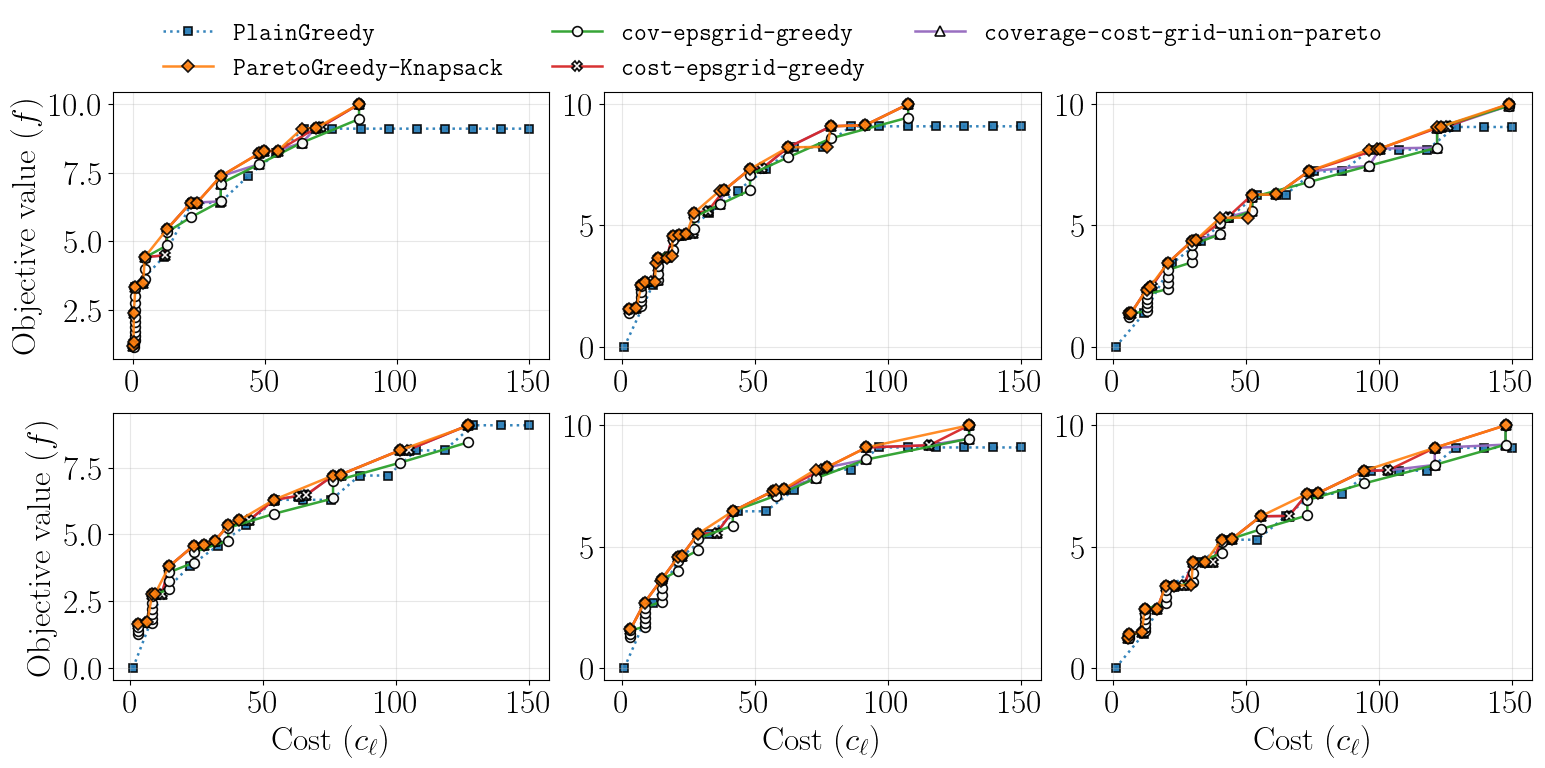

Runtime summary (seconds):
  - PlainGreedy: 0.072
  - ParetoGreedy-Knapsack: 0.054
  - cov-epsgrid-greedy: 0.057
  - cost-epsgrid-greedy: 2.425
  - coverage-cost-grid-union-pareto: 0.000


In [5]:
# Call findSingleSampleSolutions (adjust parameters as needed)
sample_size = 10
maxBudget = 150
random_seed = 42

plot_algos = {
    "ParetoGreedy-Knapsack": True,
    "cov-epsgrid-greedy": True,
    "cost-epsgrid-greedy": True,
    "coverage-cost-grid-union-pareto": True,
    "PlainGreedy": True,
    "GreedyPlus-1Guess": False,
    "TopK": False
}

findSingleSampleSolutions(
    phoenix_simMatrix, phoenix_ids, phoenix_costs,
    sample_size, maxBudget,
    dataset_name="Yelp-PHX",
    random_seed=random_seed,
    plot_algos=plot_algos,
    sample_indices=range(6)
 )

### Yelp Vegas Single Sample

In [6]:
# Import Vegas dataset
data_path = '../../datasets/pickled_data/yelp/yelp_vegas_' 

# Import pickled data
with open(data_path + 'ids.pkl', "rb") as fp:
    vegas_ids = pickle.load(fp)

with open(data_path + 'sim.pkl', "rb") as fp:
    vegas_simMatrix = pickle.load(fp)

with open(data_path + 'costs.pkl', "rb") as fp:
    vegas_costs = pickle.load(fp)

2026-02-03 17:09:26,656 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:20, Budget=200
2026-02-03 17:09:26,803 |INFO: CoverageLinear epsilon grid: eps=0.100, min_obj=1.336, max_obj=20.000, points=30
2026-02-03 17:09:26,862 |INFO: Cost epsilon grid: eps=0.100, min_cost=2.886, max_budget=200.000, points=46
2026-02-03 17:09:42,585 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:20, Budget=1.0
2026-02-03 17:09:42,586 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:20, Budget=15.214285714285714
2026-02-03 17:09:42,604 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:20, Budget=29.428571428571427
2026-02-03 17:09:42,688 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:20, Budget=43.64285714285714
2026-02-03 17:09:42,841 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:20, Budget=57.857142857142854
2026-02-03 17:09:43,080 |INFO: Initialized Pareto 

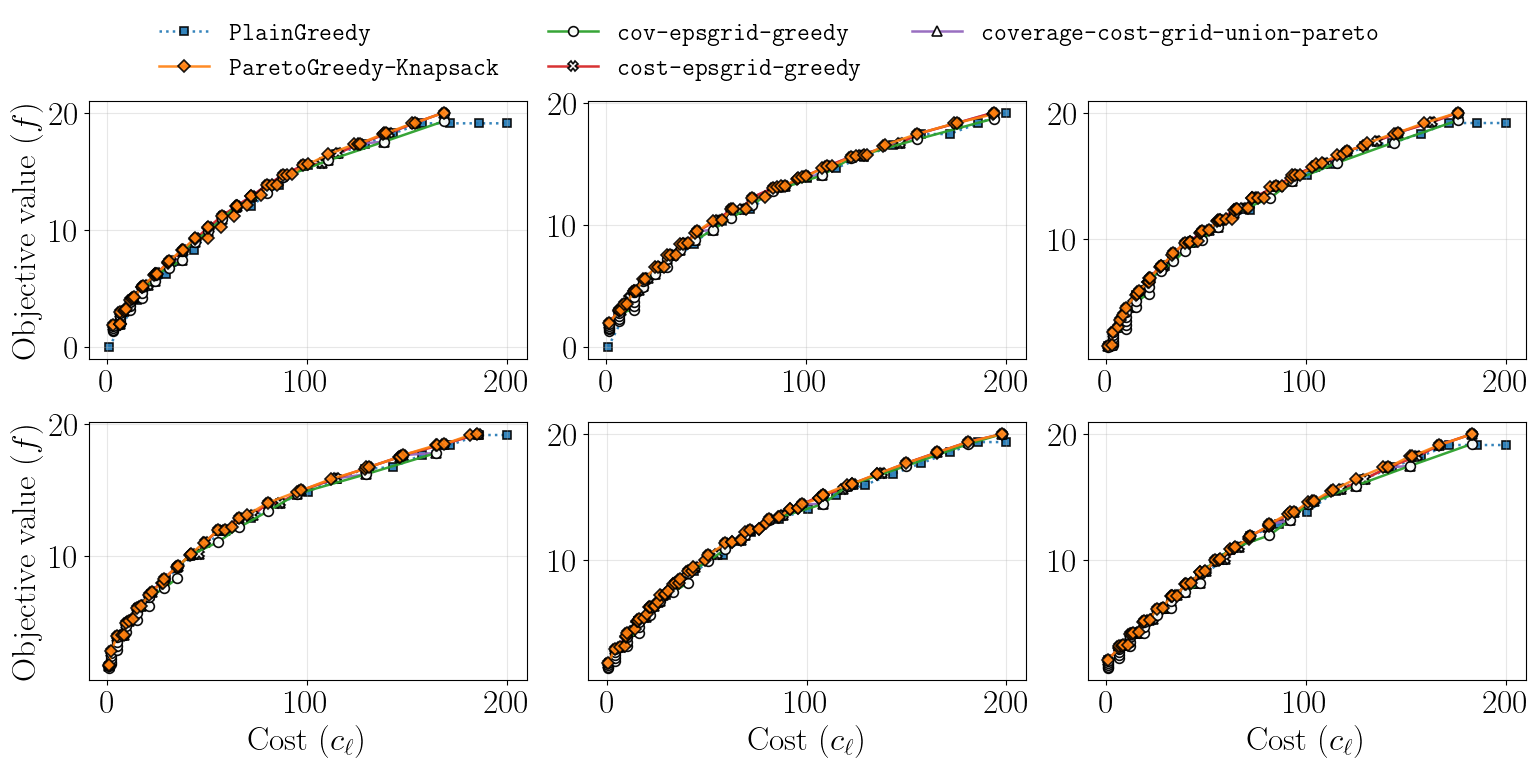

Runtime summary (seconds):
  - PlainGreedy: 0.452
  - ParetoGreedy-Knapsack: 0.819
  - cov-epsgrid-greedy: 0.322
  - cost-epsgrid-greedy: 84.479
  - coverage-cost-grid-union-pareto: 0.000


In [7]:
# Call findSingleSampleSolutions (adjust parameters as needed)
sample_size = 20
maxBudget = 200
random_seed = 42

# plot_algos = {
#     "ParetoGreedy-Knapsack": False,
#     "cov-epsgrid-greedy": True,
#     "cost-epsgrid-greedy": True,
#     "coverage-cost-grid-union-pareto": True,
#     "PlainGreedy": True,
#     "GreedyPlus-1Guess": False,
#     "TopK": False
# }

findSingleSampleSolutions(
    vegas_simMatrix, vegas_ids, vegas_costs,
    sample_size, maxBudget,
    dataset_name="Yelp-LV",
    random_seed=random_seed,
    plot_algos=plot_algos,
    sample_indices=range(6)
 )